In [1]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import os,sys

modelNames = ['ZScorePredictor','FiveDayPredictor','TmmrwUpPredictor']
verbose = False
secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
sectorFolder = 'data/by_sector'
catLabels = ['ticker','industry']

In [2]:
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    if verbose:
        myMatrix = plot_confusion_matrix(predictor, attributes, labels,
                                     cmap=plt.cm.Blues, normalize = 'all')    
        plt.show()
    return  errorScore/len(predicted)

In [3]:
def catBoostMaker(df,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, count, toSave, sector):
    catIndicies = []
    counter = -1
    for col in df.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = df.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList, tmmrwUpTrainList, tmmrwUpTestList = \
    train_test_split(masterList, zScoreAnswer, fiveDayChangeAnswer, tmmrwUpAnswer, test_size = .25)
    
    answerTrainList = [zScoreTrainList,fiveDayChangeTrainList, tmmrwUpTrainList]
    answerTestList = [zScoreTestList,fiveDayChangeTestList, tmmrwUpTestList]
    trainPools = [Pool(data = masterTrainList, label = x, cat_features = catIndicies) for x in answerTrainList]
    testPools = [Pool(data = masterTestList, label = x, cat_features = catIndicies) for x in answerTestList]
    
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    featureDF = pd.DataFrame(data = 
                         {'featureName': [col for col in df.columns],
                        'importance': [0] * len([col for col in df.columns])}).set_index('featureName')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in df.columns])
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli')
        model.fit(train, eval_set = test, logging_level = 'Silent')
        if toSave:
            model.save_model('{}-{}{}-{}.cbm'.format(folderRoot, name, sector, count))
        accuracy =  model.score(test)
        error = scoreCalculator(model, test,test.get_label())
        accuracyList.append(accuracy)
        scoreList.append(error)
        featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
        featureDFPart = pd.DataFrame(data = 
                     {'featureName': featureList['Feature Id'],
                    'importance': featureList['Importances']}).set_index('featureName')
        featureDF = featureDF + featureDFPart
        if verbose:
            print(name)
            print('Accuracy: ', accuracy)
            print('Error Score:', error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    featureList = CatBoostClassifier.get_feature_importance(model, prettified = True)
    return averageAccuracy, averageScore, featureDF

In [4]:
#returns feature to remove, mean error score, # of significant (non answer or date) columns
def buildForest(file, droppedColumns, toSave):
    sector = file.split('.')[0]
    file = sectorFolder + '/' + file
    secretColumns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'sector', 'tmmrwChngAsPerc']
    catAccuracy = []
    catError = []
    masterFeatureDF = None
    colCount = 0
    combinedDF = None
    if os.stat(file).st_size > 2000000:
        chunks = pd.read_csv(file, parse_dates = True, chunksize = 150000)
        for idx, chunk in enumerate(chunks):
            chunk.drop(columns = ['Date'], inplace = True)
            zScoreAnswer = chunk['zScoreOfChangeTmmrw']
            zScoreAnswer = zScoreAnswer.astype('float')
            zScoreAnswer = ['long' if x > .1 else 'short' if x < -.1 else 'hold' for x in zScoreAnswer ]
            fiveDayChangeAnswer = chunk['percentChangeInFiveDays']
            fiveDayChangeAnswer = ['long' if x > .005 else 'short' if x < -.005 else 'hold' for x in fiveDayChangeAnswer]
            tmmrwUpAnswer = chunk['tmmrwChngAsPerc']
            tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

            chunk.drop(columns = secretColumns, inplace = True)
            accuracy, error, featureDF = \
            catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, idx, toSave, sector)
            catAccuracy.append(accuracy)
            catError.append(error)
            if idx == 0:
                masterFeatureDF = featureDF
            else:
                masterFeatureDF = masterFeatureDF + featureDF


    else :
        combinedDF = pd.read_csv(file, parse_dates = True)
        combinedDF.drop(columns = ['Date'], inplace = True)
        zScoreAnswer = combinedDF['zScoreOfChangeTmmrw']
        zScoreAnswer = zScoreAnswer.astype('float')
        zScoreAnswer = ['long' if x > .1 else 'short' if x < -.1 else 'hold' for x in zScoreAnswer ]
        fiveDayChangeAnswer = combinedDF['percentChangeInFiveDays']
        fiveDayChangeAnswer = ['long' if x > .005 else 'short' if x < -.005 else 'hold' for x in fiveDayChangeAnswer]
        tmmrwUpAnswer = combinedDF['tmmrwChngAsPerc']
        tmmrwUpAnswer = ['long' if x > 0 else 'short' for x in tmmrwUpAnswer]

        combinedDF.drop(columns = secretColumns, inplace = True)
        accuracy, error, featureDF = \
        catBoostMaker(chunk,zScoreAnswer,fiveDayChangeAnswer, tmmrwUpAnswer, catLabels, idx, toSave, sector)
        catAccuracy.append(accuracy)
        catError.append(error)
        masterFeatureDF = featureDF
            
    print('-------------------------------------------\n\n')
    print('Final Catboost accuracy: ', mean(catAccuracy))
    print('Final Catboost score: ' ,mean(catError))
    print('Final Feature Importance:', masterFeatureDF)
    featureToRemove = masterFeatureDF['importance'].idxmin()
    print(featureToRemove)
    return featureToRemove, mean(catError), colCount, masterFeatureDF

Basic Materials
-------------------------------------------


Final Catboost accuracy:  0.6555663808971557
Final Catboost score:  8.140514087752948
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.166044
BOPGSTBValue                     1.428433
BOPGSTBbPercent                  1.259883
BOPGSTBfiveVsTenTickAverage      1.031036
BOPGSTBlastChangeP               2.628818
...                                   ...
titleSentChangeSinceYesterday    9.526827
todayZScore                     13.428112
totalVolumeOfTheDay              9.277383
typPrice                        33.689662
vsMarketPerformance              9.455786

[158 rows x 1 columns]
DPRIMElastChangeP
['DPRIMElastChangeP']
-------------------------------------------


Final Catboost accuracy:  0.6554288320918269
Final Catboost score:  8.133267520109431
Final Feature Importance:                                importance
featureName     

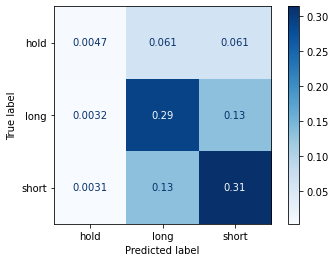

ZScorePredictor
Accuracy:  0.6079733333333334
Error Score: 7.150133333333334


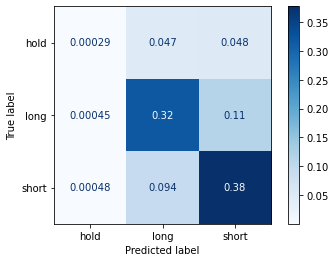

FiveDayPredictor
Accuracy:  0.6961066666666667
Error Score: 9.991066666666667


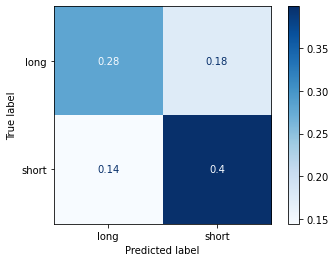

TmmrwUpPredictor
Accuracy:  0.6806933333333334
Error Score: 7.9484


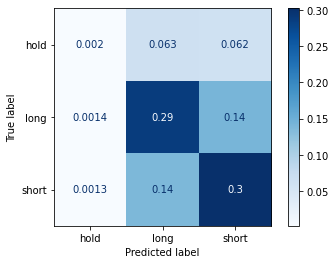

ZScorePredictor
Accuracy:  0.59224
Error Score: 6.590933333333333


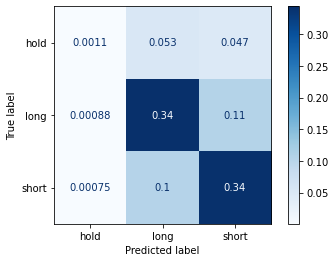

FiveDayPredictor
Accuracy:  0.6874666666666667
Error Score: 9.761866666666666


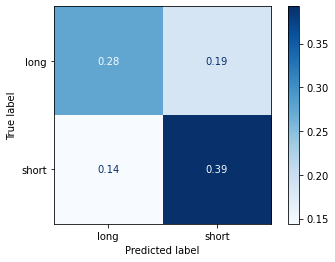

TmmrwUpPredictor
Accuracy:  0.6693866666666667
Error Score: 7.4956


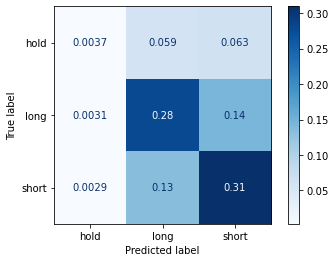

ZScorePredictor
Accuracy:  0.5927739863508631
Error Score: 6.58048976314733


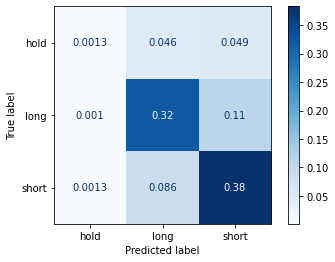

FiveDayPredictor
Accuracy:  0.7071858691288639
Error Score: 10.406262545162585


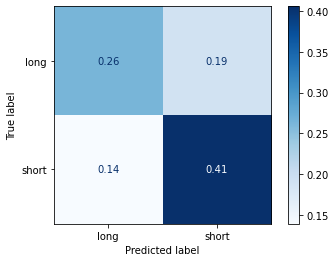

TmmrwUpPredictor
Accuracy:  0.669690887193898
Error Score: 7.483340024086712
-------------------------------------------


Final Catboost accuracy:  0.6559463788155879
Final Catboost score:  8.156454703599625
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.384707
BOPGSTBValue                     1.629404
BOPGSTBbPercent                  1.496969
BOPGSTBfiveVsTenTickAverage      1.200016
BOPGSTBlastChangeP               1.665946
...                                   ...
titleSentChangeSinceYesterday    9.408515
todayZScore                     12.396862
totalVolumeOfTheDay             10.053380
typPrice                        34.622486
vsMarketPerformance              9.794094

[158 rows x 1 columns]
PCEC96Value
Communication Services
-------------------------------------------


Final Catboost accuracy:  0.6216088662902582
Final Catboost score:  6.932371950862103
Final Feature Importance:   

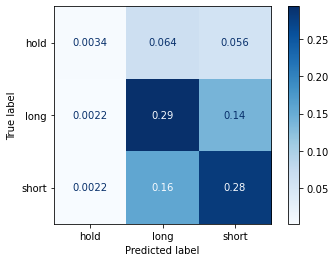

ZScorePredictor
Accuracy:  0.57816
Error Score: 6.023866666666667


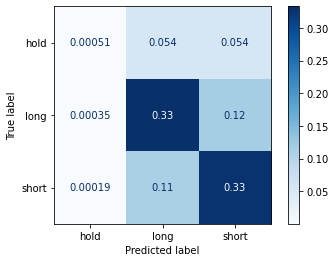

FiveDayPredictor
Accuracy:  0.66184
Error Score: 8.923733333333333


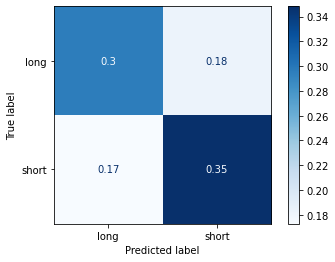

TmmrwUpPredictor
Accuracy:  0.6444533333333333
Error Score: 6.641866666666667


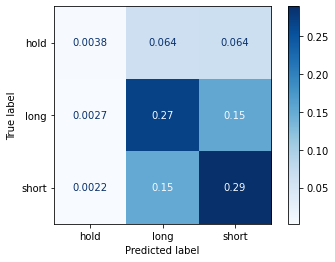

ZScorePredictor
Accuracy:  0.5610133333333334
Error Score: 5.4568


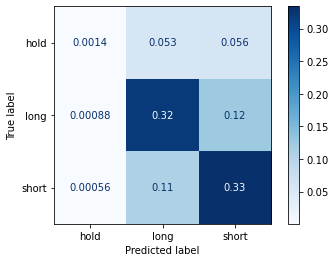

FiveDayPredictor
Accuracy:  0.6559466666666667
Error Score: 8.708


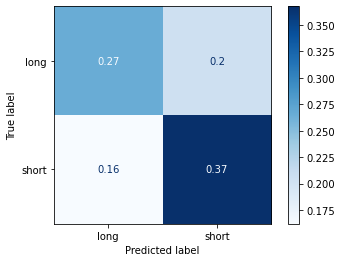

TmmrwUpPredictor
Accuracy:  0.6336
Error Score: 6.154133333333333


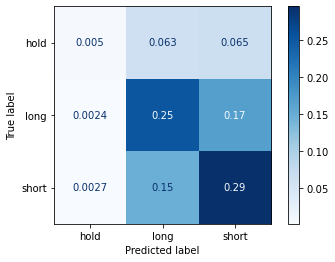

ZScorePredictor
Accuracy:  0.5517208504147202
Error Score: 5.056726094003242


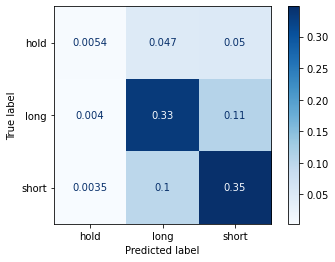

FiveDayPredictor
Accuracy:  0.6871007722375823
Error Score: 9.734960434741158


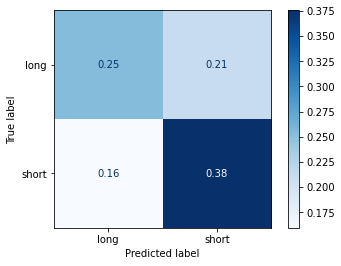

TmmrwUpPredictor
Accuracy:  0.6288492706645057
Error Score: 5.951949661550195
-------------------------------------------


Final Catboost accuracy:  0.6225204696277935
Final Catboost score:  6.961337354477178
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.143304
BOPGSTBValue                     2.271596
BOPGSTBbPercent                  1.773884
BOPGSTBfiveVsTenTickAverage      1.767670
BOPGSTBlastChangeP               3.362128
...                                   ...
titleSentChangeSinceYesterday    8.667720
todayZScore                     12.582274
totalVolumeOfTheDay              9.655669
typPrice                        29.896250
vsMarketPerformance             11.581257

[158 rows x 1 columns]
DPRIMElastChangeP
Consumer Cyclical
-------------------------------------------


Final Catboost accuracy:  0.6431208233366109
Final Catboost score:  7.748231622418879
Final Feature Importance: 

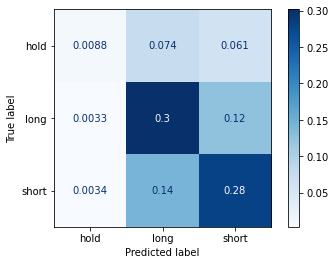

ZScorePredictor
Accuracy:  0.5902133333333334
Error Score: 6.615733333333333


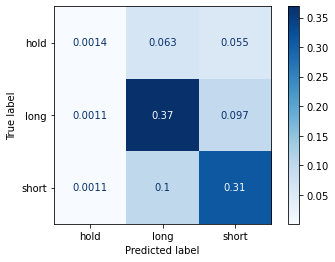

FiveDayPredictor
Accuracy:  0.68248
Error Score: 9.856666666666667


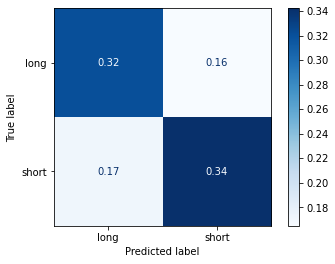

TmmrwUpPredictor
Accuracy:  0.6633333333333333
Error Score: 7.392


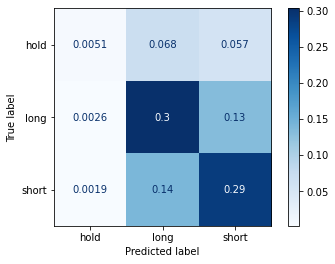

ZScorePredictor
Accuracy:  0.5970666666666666
Error Score: 6.7244


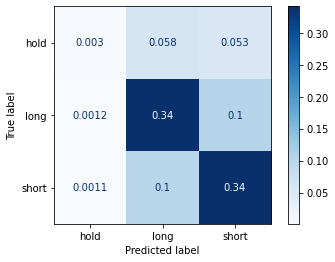

FiveDayPredictor
Accuracy:  0.6847733333333333
Error Score: 9.799733333333334


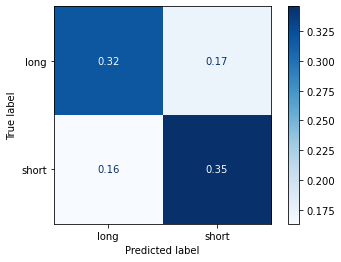

TmmrwUpPredictor
Accuracy:  0.6640266666666667
Error Score: 7.3772


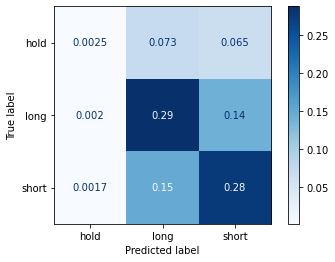

ZScorePredictor
Accuracy:  0.56696
Error Score: 5.850266666666666


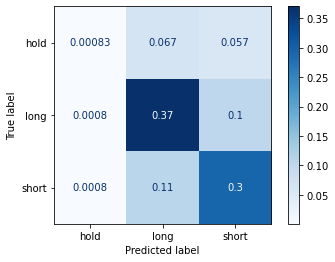

FiveDayPredictor
Accuracy:  0.6661866666666667
Error Score: 9.324533333333333


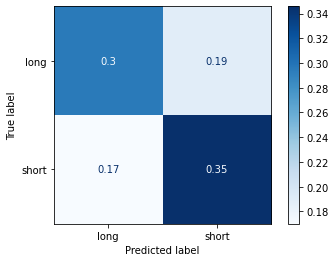

TmmrwUpPredictor
Accuracy:  0.6410666666666667
Error Score: 6.492666666666667


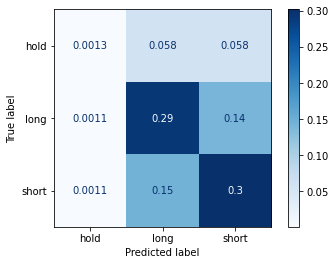

ZScorePredictor
Accuracy:  0.5953066666666667
Error Score: 6.5848


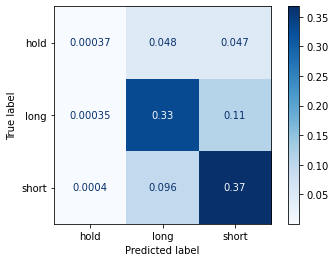

FiveDayPredictor
Accuracy:  0.6973066666666666
Error Score: 10.0332


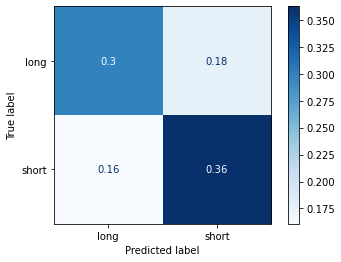

TmmrwUpPredictor
Accuracy:  0.66112
Error Score: 7.2488


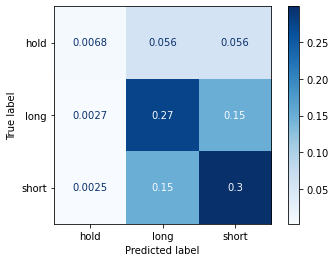

ZScorePredictor
Accuracy:  0.5800762045231072
Error Score: 5.886492133726647


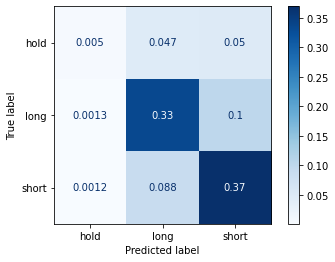

FiveDayPredictor
Accuracy:  0.70968534906588
Error Score: 10.475049164208457


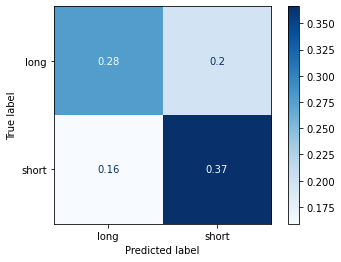

TmmrwUpPredictor
Accuracy:  0.6441125860373648
Error Score: 6.5588126843657815
-------------------------------------------


Final Catboost accuracy:  0.6429142759750901
Final Catboost score:  7.748023598820059
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.783528
BOPGSTBValue                     1.592040
BOPGSTBbPercent                  3.687227
BOPGSTBfiveVsTenTickAverage      2.001054
BOPGSTBlastChangeP               3.195355
...                                   ...
titleSentChangeSinceYesterday   15.019928
todayZScore                     18.715803
totalVolumeOfTheDay             19.005444
typPrice                        50.304651
vsMarketPerformance             15.492843

[158 rows x 1 columns]
DPRIMElastChangeP
Consumer Defensive
-------------------------------------------


Final Catboost accuracy:  0.6091872344071523
Final Catboost score:  6.6006053866520595
Final Feature Importanc

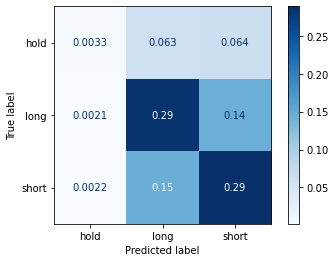

ZScorePredictor
Accuracy:  0.5774133333333333
Error Score: 6.075066666666666


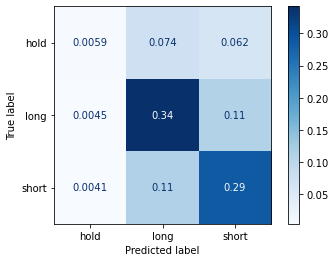

FiveDayPredictor
Accuracy:  0.6355733333333333
Error Score: 8.3792


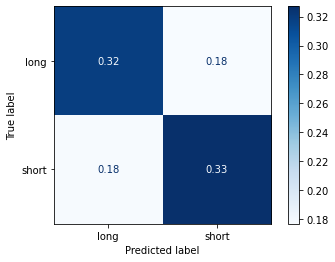

TmmrwUpPredictor
Accuracy:  0.64576
Error Score: 6.717866666666667


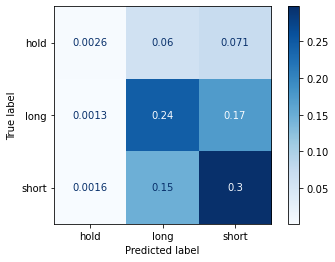

ZScorePredictor
Accuracy:  0.5449718728272549
Error Score: 4.867423045319512


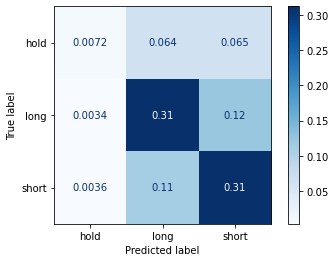

FiveDayPredictor
Accuracy:  0.6299538587952721
Error Score: 8.00581505593831


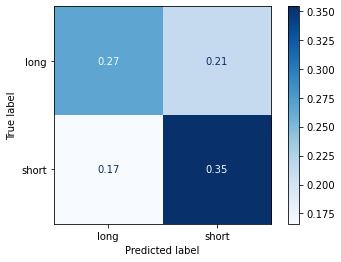

TmmrwUpPredictor
Accuracy:  0.6207888249794576
Error Score: 5.661778648631565
-------------------------------------------


Final Catboost accuracy:  0.6090768705447753
Final Catboost score:  6.617858347203787
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.087309
BOPGSTBValue                     1.729938
BOPGSTBbPercent                  1.121828
BOPGSTBfiveVsTenTickAverage      0.990767
BOPGSTBlastChangeP               2.025524
...                                   ...
titleSentChangeSinceYesterday    4.774789
todayZScore                      7.897643
totalVolumeOfTheDay              6.184371
typPrice                        22.360870
vsMarketPerformance              6.278425

[158 rows x 1 columns]
DPRIMEValue
Energy
-------------------------------------------


Final Catboost accuracy:  0.6629418284921119
Final Catboost score:  8.442796458798835
Final Feature Importance:                  

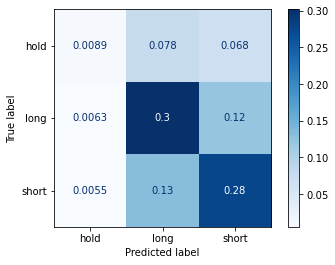

ZScorePredictor
Accuracy:  0.5863733333333333
Error Score: 6.714666666666667


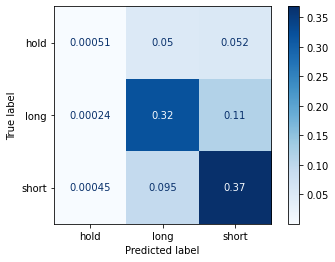

FiveDayPredictor
Accuracy:  0.6884266666666666
Error Score: 9.806133333333333


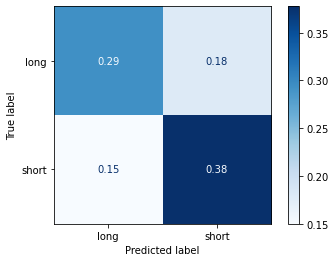

TmmrwUpPredictor
Accuracy:  0.6716
Error Score: 7.613466666666667


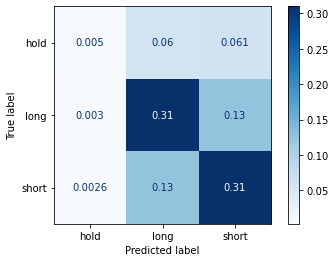

ZScorePredictor
Accuracy:  0.6225066666666667
Error Score: 7.655733333333333


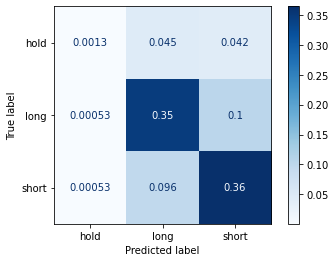

FiveDayPredictor
Accuracy:  0.7120533333333333
Error Score: 10.476533333333334


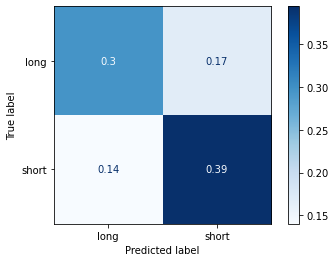

TmmrwUpPredictor
Accuracy:  0.6909866666666666
Error Score: 8.340533333333333


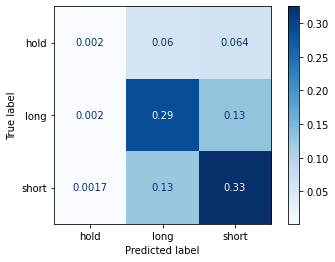

ZScorePredictor
Accuracy:  0.6145452468007313
Error Score: 7.419589808043876


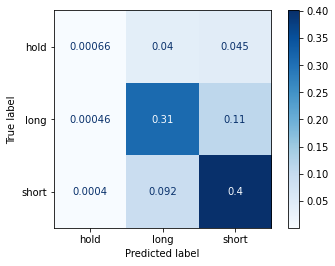

FiveDayPredictor
Accuracy:  0.7114373857404022
Error Score: 10.416333409506398


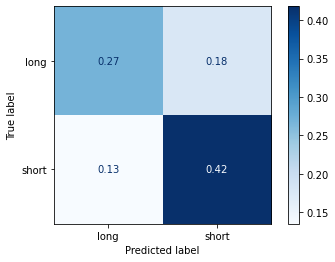

TmmrwUpPredictor
Accuracy:  0.6876142595978062
Error Score: 8.179130484460694
-------------------------------------------


Final Catboost accuracy:  0.6650603954228451
Final Catboost score:  8.51356892985307
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.256396
BOPGSTBValue                     1.152403
BOPGSTBbPercent                  1.386917
BOPGSTBfiveVsTenTickAverage      0.714296
BOPGSTBlastChangeP               1.473524
...                                   ...
titleSentChangeSinceYesterday    8.715323
todayZScore                     10.030523
totalVolumeOfTheDay              9.730634
typPrice                        24.777262
vsMarketPerformance              8.594086

[158 rows x 1 columns]
DPRIMElastChangeP
Financial Services
-------------------------------------------


Final Catboost accuracy:  0.6483882106325398
Final Catboost score:  8.069308099016865
Final Feature Importance: 

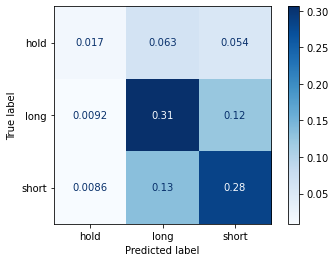

ZScorePredictor
Accuracy:  0.6062933333333334
Error Score: 6.968933333333333


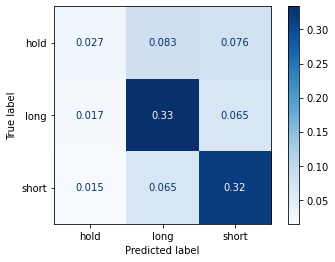

FiveDayPredictor
Accuracy:  0.67888
Error Score: 10.3512


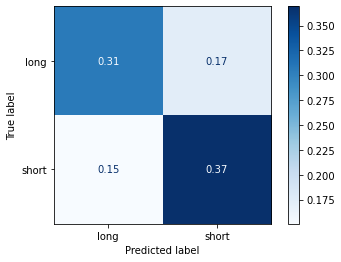

TmmrwUpPredictor
Accuracy:  0.6760533333333333
Error Score: 7.7956


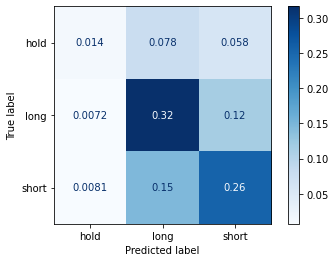

ZScorePredictor
Accuracy:  0.5863733333333333
Error Score: 6.5492


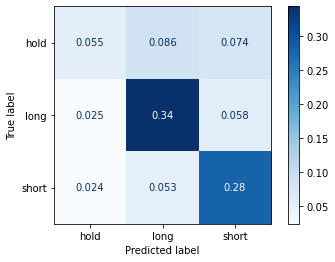

FiveDayPredictor
Accuracy:  0.6789866666666666
Error Score: 10.0772


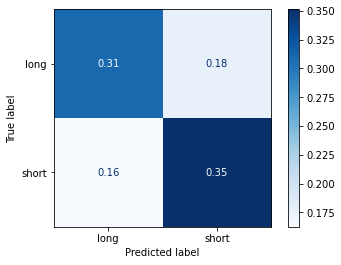

TmmrwUpPredictor
Accuracy:  0.6611466666666667
Error Score: 7.258


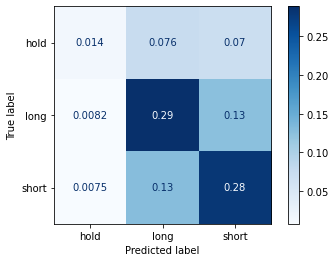

ZScorePredictor
Accuracy:  0.58344
Error Score: 6.5536


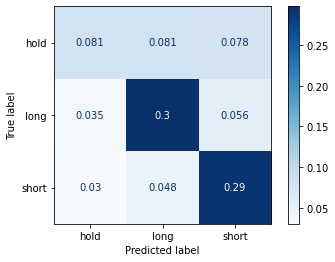

FiveDayPredictor
Accuracy:  0.6715733333333334
Error Score: 9.565333333333333


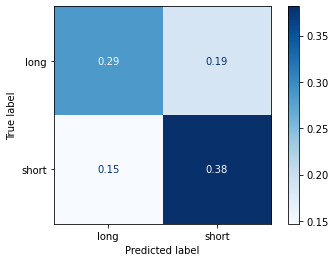

TmmrwUpPredictor
Accuracy:  0.66704
Error Score: 7.4156


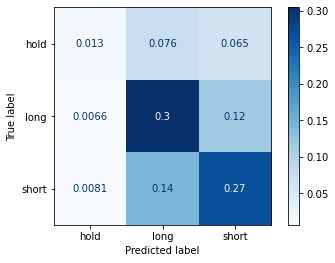

ZScorePredictor
Accuracy:  0.58536
Error Score: 6.594266666666667


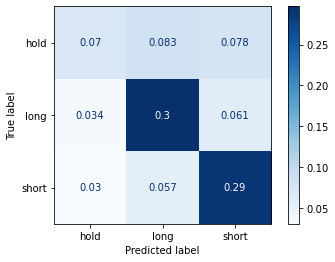

FiveDayPredictor
Accuracy:  0.6574666666666666
Error Score: 9.253333333333334


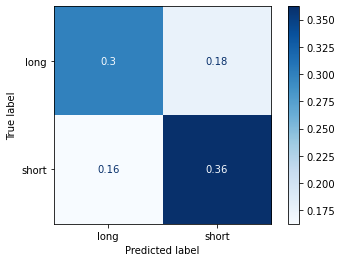

TmmrwUpPredictor
Accuracy:  0.66128
Error Score: 7.2644


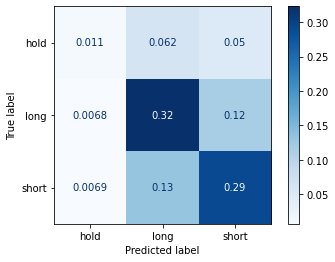

ZScorePredictor
Accuracy:  0.6256
Error Score: 7.6564


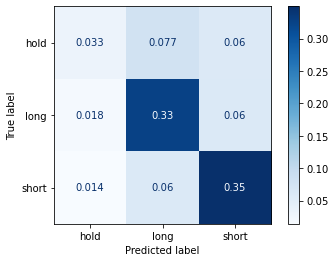

FiveDayPredictor
Accuracy:  0.7106666666666667
Error Score: 11.060133333333333


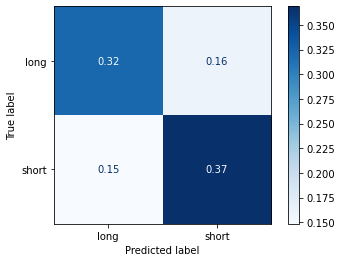

TmmrwUpPredictor
Accuracy:  0.6906133333333333
Error Score: 8.366533333333333


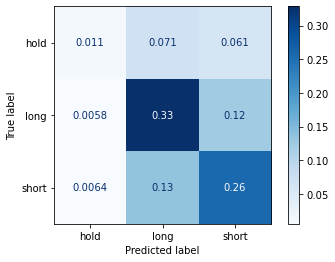

ZScorePredictor
Accuracy:  0.5982933333333333
Error Score: 6.897333333333333


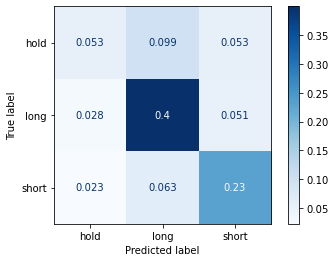

FiveDayPredictor
Accuracy:  0.68336
Error Score: 10.150933333333333


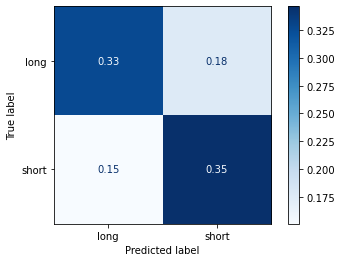

TmmrwUpPredictor
Accuracy:  0.67328
Error Score: 7.6841333333333335


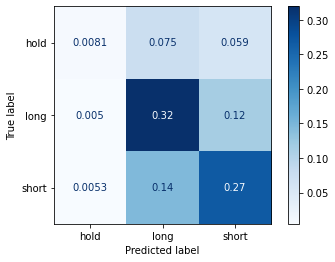

ZScorePredictor
Accuracy:  0.5952266666666667
Error Score: 6.8848


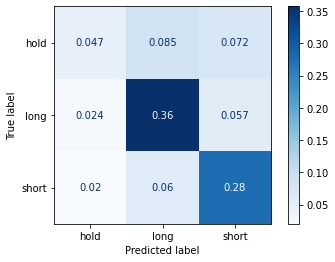

FiveDayPredictor
Accuracy:  0.6814933333333333
Error Score: 10.2264


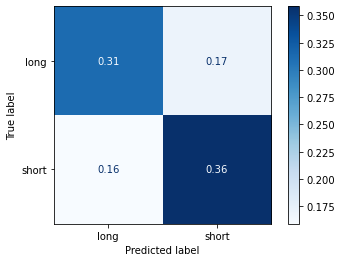

TmmrwUpPredictor
Accuracy:  0.6712
Error Score: 7.642


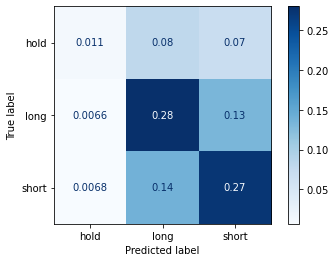

ZScorePredictor
Accuracy:  0.56464
Error Score: 5.923066666666666


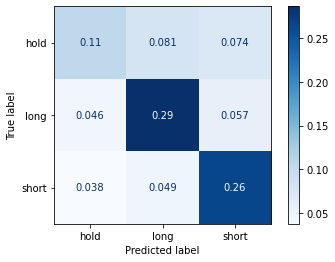

FiveDayPredictor
Accuracy:  0.6558666666666667
Error Score: 8.7324


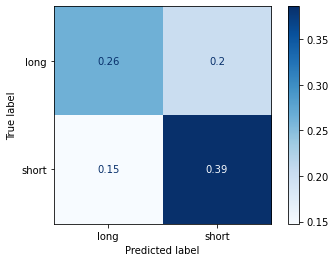

TmmrwUpPredictor
Accuracy:  0.6503733333333334
Error Score: 6.7528


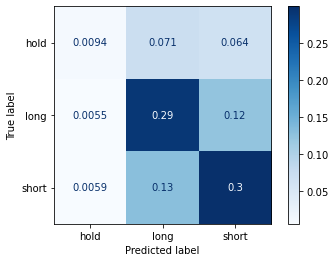

ZScorePredictor
Accuracy:  0.5995466666666667
Error Score: 7.023733333333333


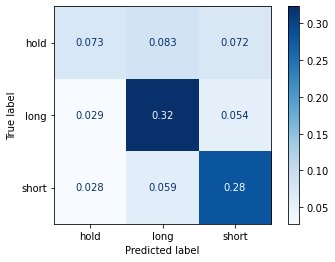

FiveDayPredictor
Accuracy:  0.6762133333333333
Error Score: 9.683466666666666


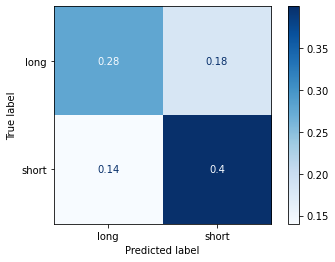

TmmrwUpPredictor
Accuracy:  0.6785866666666667
Error Score: 7.844133333333334


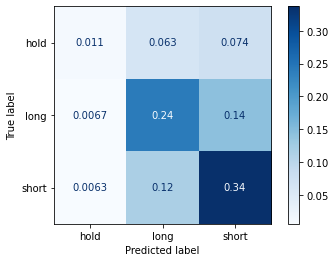

ZScorePredictor
Accuracy:  0.5887733333333334
Error Score: 6.611466666666667


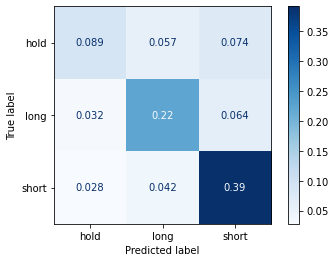

FiveDayPredictor
Accuracy:  0.7028
Error Score: 10.076666666666666


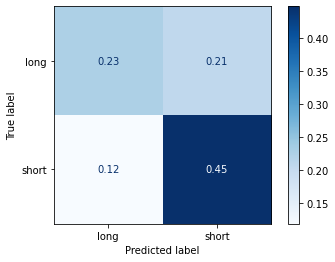

TmmrwUpPredictor
Accuracy:  0.6747466666666667
Error Score: 7.581333333333333


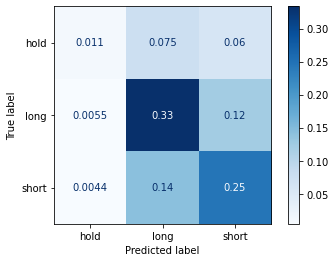

ZScorePredictor
Accuracy:  0.5899466666666666
Error Score: 6.612133333333333


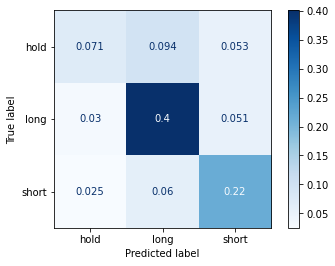

FiveDayPredictor
Accuracy:  0.6866933333333334
Error Score: 9.925066666666666


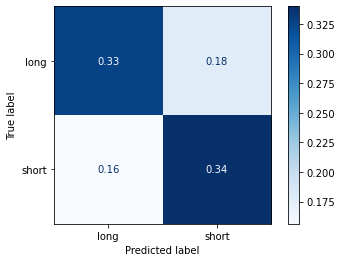

TmmrwUpPredictor
Accuracy:  0.6666666666666666
Error Score: 7.447866666666667


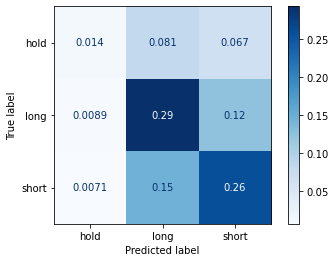

ZScorePredictor
Accuracy:  0.56632
Error Score: 5.979333333333333


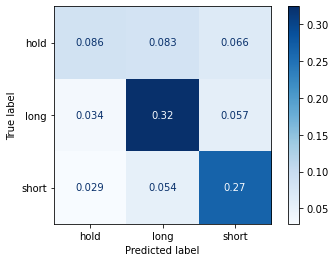

FiveDayPredictor
Accuracy:  0.6767733333333333
Error Score: 9.458933333333333


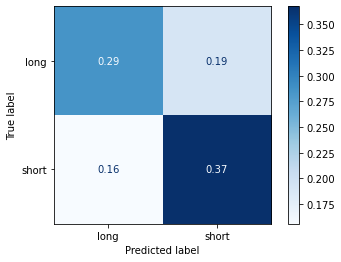

TmmrwUpPredictor
Accuracy:  0.6529066666666666
Error Score: 6.895866666666667


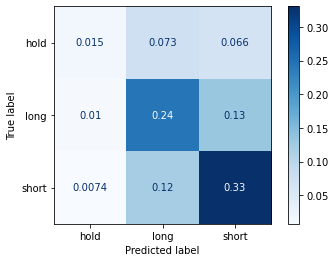

ZScorePredictor
Accuracy:  0.5897808586762076
Error Score: 6.674306797853309


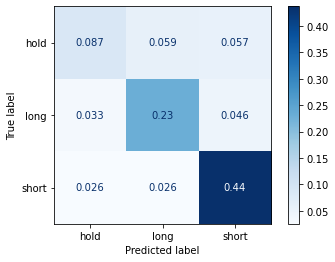

FiveDayPredictor
Accuracy:  0.7541368515205724
Error Score: 11.74698121645796


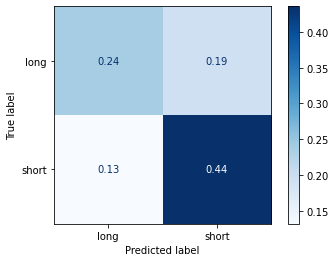

TmmrwUpPredictor
Accuracy:  0.6738595706618963
Error Score: 7.614601967799643
-------------------------------------------


Final Catboost accuracy:  0.6485194174579147
Final Catboost score:  8.0717817944131
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  2.598004
BOPGSTBValue                     2.015384
BOPGSTBbPercent                  2.146410
BOPGSTBfiveVsTenTickAverage      2.689560
BOPGSTBlastChangeP               4.869310
...                                   ...
titleSentChangeSinceYesterday   31.181415
todayZScore                     56.561146
totalVolumeOfTheDay             34.833541
typPrice                       108.303571
vsMarketPerformance             48.393426

[158 rows x 1 columns]
DPRIMElastChangeP
Financial
-------------------------------------------


Final Catboost accuracy:  0.5372769953051643
Final Catboost score:  3.970892018779343
Final Feature Importance:           

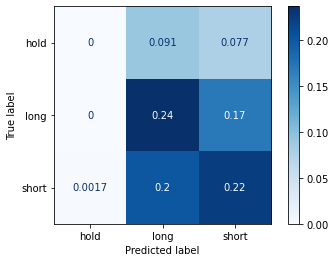

ZScorePredictor
Accuracy:  0.4597183098591549
Error Score: 2.332394366197183


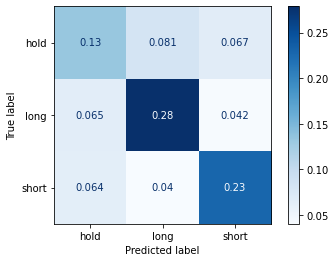

FiveDayPredictor
Accuracy:  0.6411267605633802
Error Score: 8.32394366197183


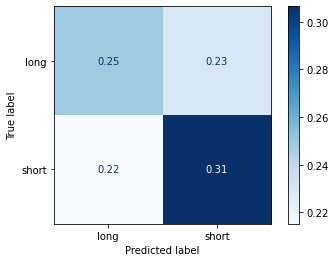

TmmrwUpPredictor
Accuracy:  0.5554929577464789
Error Score: 3.295774647887324
-------------------------------------------


Final Catboost accuracy:  0.5521126760563381
Final Catboost score:  4.650704225352112
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  0.414669
BOPGSTBValue                     2.042087
BOPGSTBbPercent                  1.110369
BOPGSTBfiveVsTenTickAverage      1.317008
BOPGSTBlastChangeP               1.675429
...                                   ...
titleSentChangeSinceYesterday    2.059016
todayZScore                      2.892067
totalVolumeOfTheDay              1.604840
typPrice                         6.944217
vsMarketPerformance              2.140206

[158 rows x 1 columns]
DPRIMElastChangeP
Healthcare
-------------------------------------------


Final Catboost accuracy:  0.6417937668161435
Final Catboost score:  7.523112705530643
Final Feature Importance:        

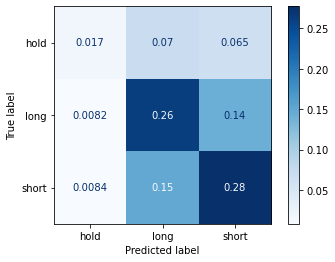

ZScorePredictor
Accuracy:  0.5572533333333334
Error Score: 5.382266666666666


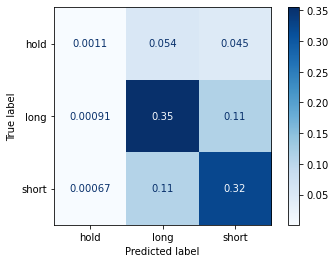

FiveDayPredictor
Accuracy:  0.67832
Error Score: 9.395866666666667


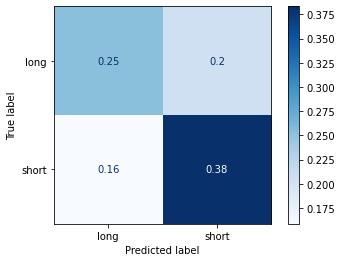

TmmrwUpPredictor
Accuracy:  0.6365866666666666
Error Score: 6.2568


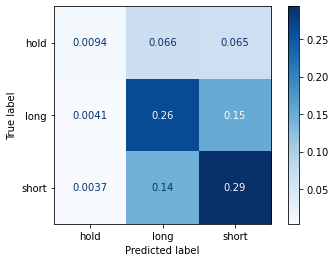

ZScorePredictor
Accuracy:  0.56592
Error Score: 5.6196


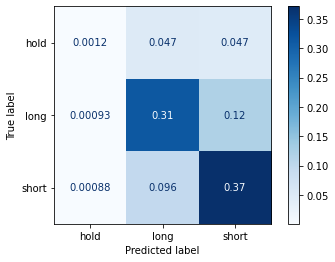

FiveDayPredictor
Accuracy:  0.6875733333333334
Error Score: 9.6488


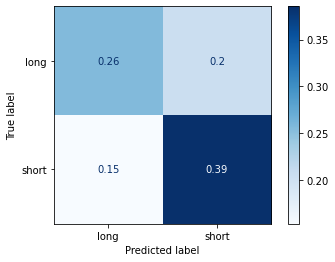

TmmrwUpPredictor
Accuracy:  0.64184
Error Score: 6.439466666666666


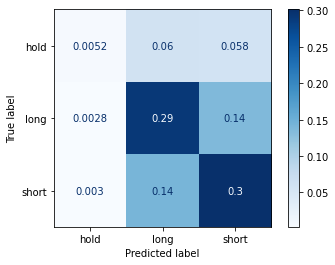

ZScorePredictor
Accuracy:  0.5971733333333333
Error Score: 6.6816


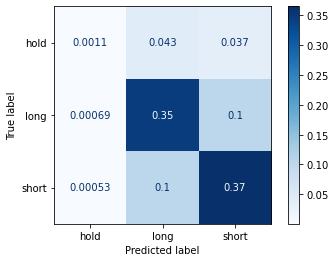

FiveDayPredictor
Accuracy:  0.7141333333333333
Error Score: 10.456266666666666


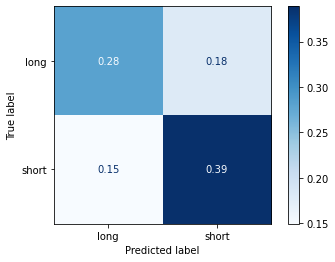

TmmrwUpPredictor
Accuracy:  0.67056
Error Score: 7.57


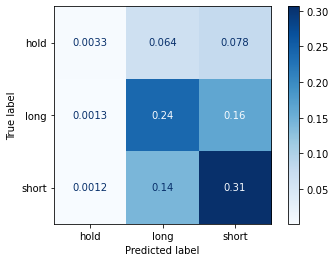

ZScorePredictor
Accuracy:  0.54976
Error Score: 5.194266666666667


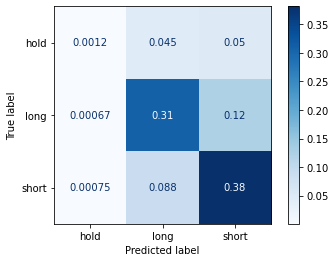

FiveDayPredictor
Accuracy:  0.6928533333333333
Error Score: 9.8272


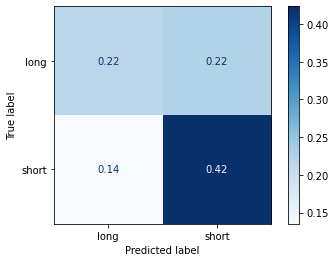

TmmrwUpPredictor
Accuracy:  0.6405866666666666
Error Score: 6.2992


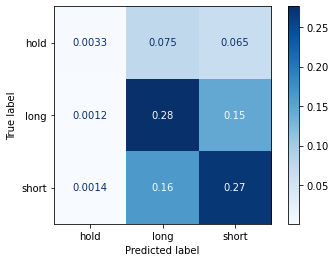

ZScorePredictor
Accuracy:  0.5473333333333333
Error Score: 5.1316


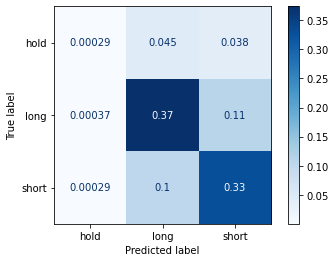

FiveDayPredictor
Accuracy:  0.70352
Error Score: 10.109333333333334


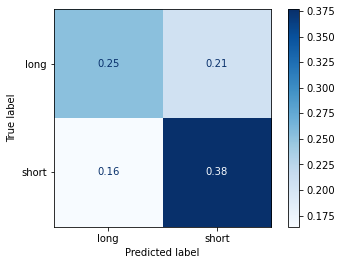

TmmrwUpPredictor
Accuracy:  0.6304266666666667
Error Score: 6.037066666666667


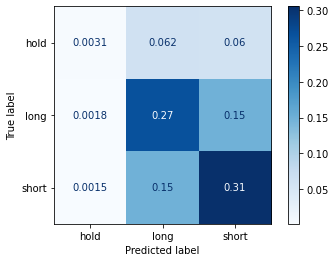

ZScorePredictor
Accuracy:  0.5752
Error Score: 5.8856


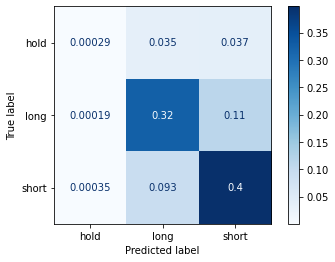

FiveDayPredictor
Accuracy:  0.7227733333333334
Error Score: 10.6308


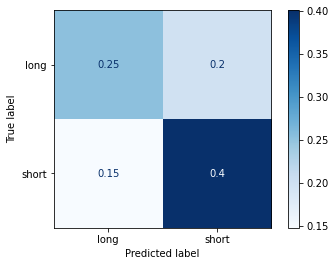

TmmrwUpPredictor
Accuracy:  0.6537333333333334
Error Score: 6.8904


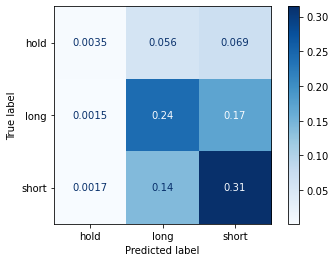

ZScorePredictor
Accuracy:  0.55976
Error Score: 5.3074666666666666


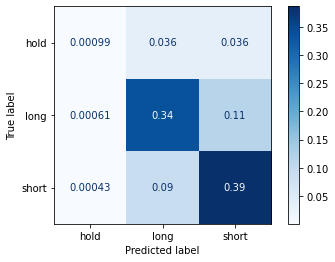

FiveDayPredictor
Accuracy:  0.72344
Error Score: 10.648


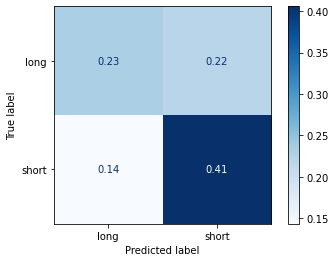

TmmrwUpPredictor
Accuracy:  0.6369066666666666
Error Score: 6.193333333333333


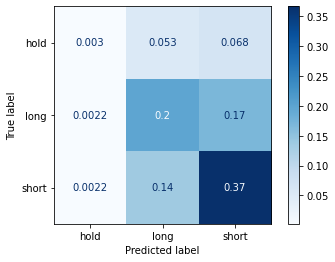

ZScorePredictor
Accuracy:  0.5680119581464873
Error Score: 5.590433482810164


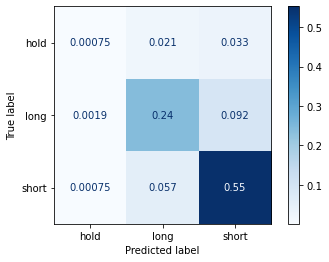

FiveDayPredictor
Accuracy:  0.7944693572496263
Error Score: 13.077354260089686


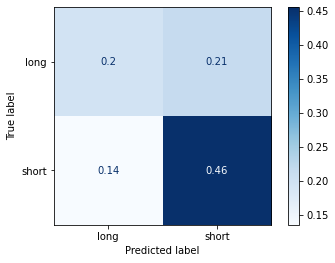

TmmrwUpPredictor
Accuracy:  0.6505979073243647
Error Score: 6.700298953662182
-------------------------------------------


Final Catboost accuracy:  0.6416138565022421
Final Catboost score:  7.540542501245641
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.586087
BOPGSTBValue                     2.663456
BOPGSTBbPercent                  3.814858
BOPGSTBfiveVsTenTickAverage      1.494268
BOPGSTBlastChangeP               3.398090
...                                   ...
titleSentChangeSinceYesterday   21.653051
todayZScore                     39.666002
totalVolumeOfTheDay             26.223989
typPrice                        80.589618
vsMarketPerformance             31.284733

[158 rows x 1 columns]
DPRIMElastChangeP
Industrials
-------------------------------------------


Final Catboost accuracy:  0.6536122376800841
Final Catboost score:  8.154438780683856
Final Feature Importance:       

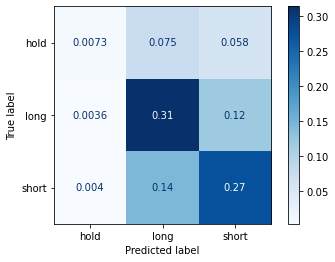

ZScorePredictor
Accuracy:  0.5954933333333333
Error Score: 6.8344


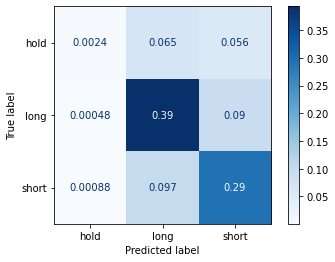

FiveDayPredictor
Accuracy:  0.6902933333333333
Error Score: 10.167066666666667


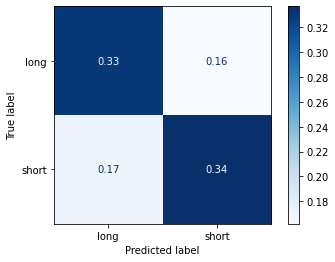

TmmrwUpPredictor
Accuracy:  0.6678666666666667
Error Score: 7.566


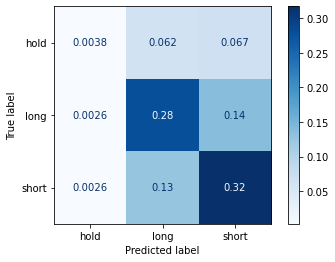

ZScorePredictor
Accuracy:  0.60112
Error Score: 6.9788


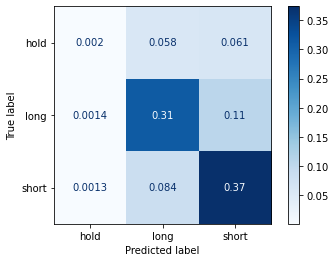

FiveDayPredictor
Accuracy:  0.6883733333333333
Error Score: 10.060133333333333


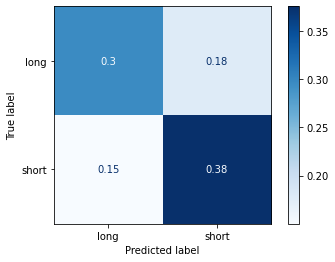

TmmrwUpPredictor
Accuracy:  0.67192
Error Score: 7.6276


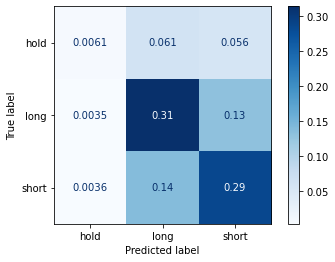

ZScorePredictor
Accuracy:  0.6053866666666666
Error Score: 6.9712


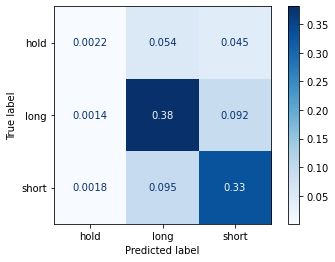

FiveDayPredictor
Accuracy:  0.7120266666666667
Error Score: 10.668533333333333


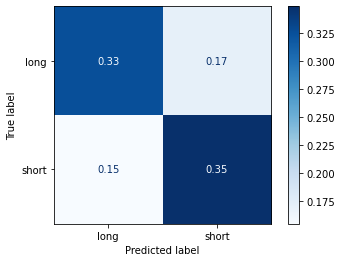

TmmrwUpPredictor
Accuracy:  0.6738933333333333
Error Score: 7.729733333333333


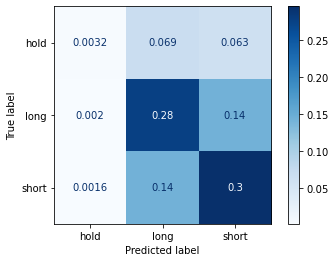

ZScorePredictor
Accuracy:  0.5763733333333333
Error Score: 6.084666666666666


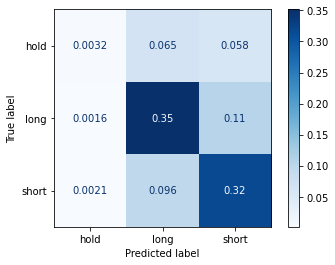

FiveDayPredictor
Accuracy:  0.6714133333333333
Error Score: 9.4832


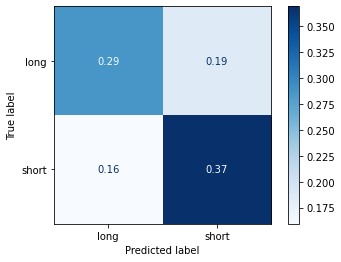

TmmrwUpPredictor
Accuracy:  0.65496
Error Score: 6.9956


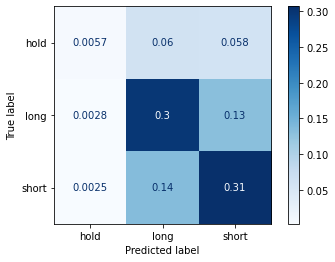

ZScorePredictor
Accuracy:  0.6104533333333333
Error Score: 7.149333333333334


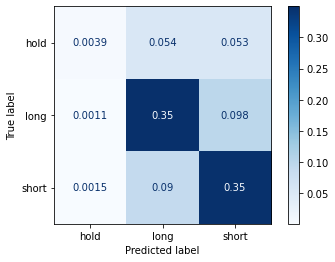

FiveDayPredictor
Accuracy:  0.70192
Error Score: 10.368933333333333


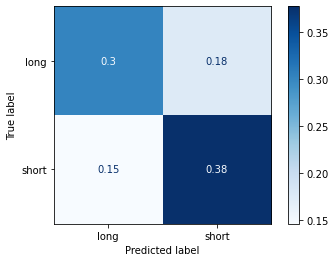

TmmrwUpPredictor
Accuracy:  0.6790133333333334
Error Score: 7.8890666666666664


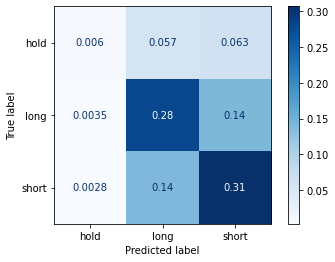

ZScorePredictor
Accuracy:  0.5922834353552217
Error Score: 6.501947690595437


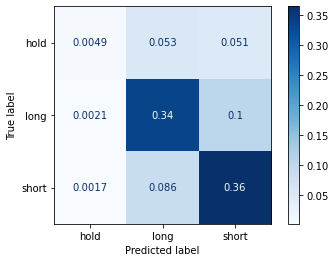

FiveDayPredictor
Accuracy:  0.7042478204414765
Error Score: 10.381376368020776


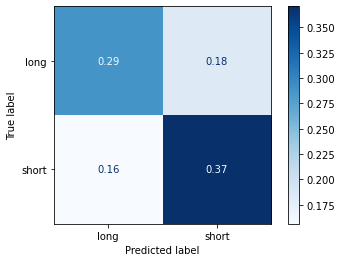

TmmrwUpPredictor
Accuracy:  0.6590613986273419
Error Score: 7.143758115377481
-------------------------------------------


Final Catboost accuracy:  0.6531166289494836
Final Catboost score:  8.144519380036687
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.844142
BOPGSTBValue                     2.830442
BOPGSTBbPercent                  3.595549
BOPGSTBfiveVsTenTickAverage      2.139268
BOPGSTBlastChangeP               2.973709
...                                   ...
titleSentChangeSinceYesterday   17.874128
todayZScore                     21.701570
totalVolumeOfTheDay             17.132557
typPrice                        66.569500
vsMarketPerformance             19.667196

[158 rows x 1 columns]
DPRIMElastChangeP
Real Estate
-------------------------------------------


Final Catboost accuracy:  0.6673735259495116
Final Catboost score:  8.901277971754666
Final Feature Importance:       

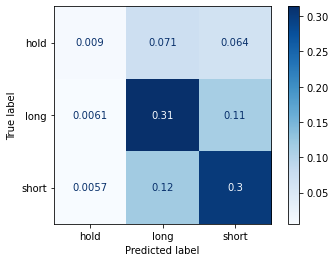

ZScorePredictor
Accuracy:  0.62416
Error Score: 7.942


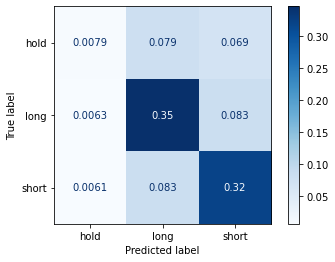

FiveDayPredictor
Accuracy:  0.67448
Error Score: 10.0336


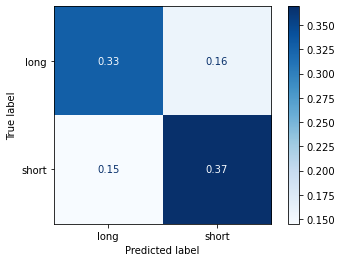

TmmrwUpPredictor
Accuracy:  0.6980533333333333
Error Score: 8.647466666666666


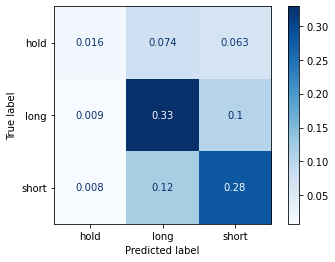

ZScorePredictor
Accuracy:  0.6234933333333333
Error Score: 7.926


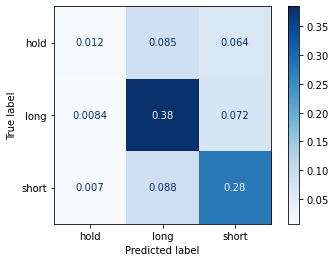

FiveDayPredictor
Accuracy:  0.67648
Error Score: 10.118933333333333


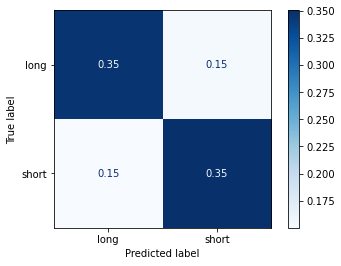

TmmrwUpPredictor
Accuracy:  0.6975466666666666
Error Score: 8.652


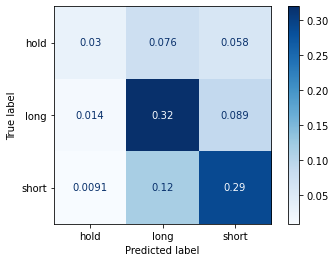

ZScorePredictor
Accuracy:  0.6382822386414663
Error Score: 8.262848512062702


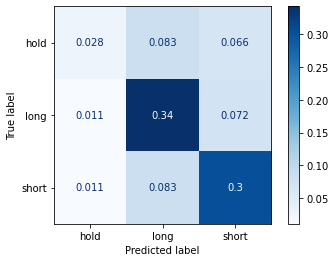

FiveDayPredictor
Accuracy:  0.6729395436175858
Error Score: 9.796505694574845


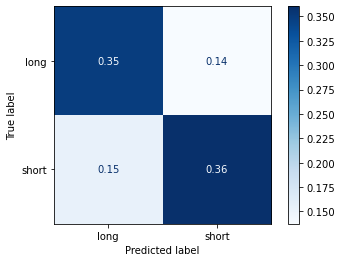

TmmrwUpPredictor
Accuracy:  0.709066416295873
Error Score: 9.130505776217497
-------------------------------------------


Final Catboost accuracy:  0.6682779479875843
Final Catboost score:  8.945539998095004
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.211254
BOPGSTBValue                     1.670393
BOPGSTBbPercent                  1.463454
BOPGSTBfiveVsTenTickAverage      1.246662
BOPGSTBlastChangeP               2.921240
...                                   ...
titleSentChangeSinceYesterday    9.973338
todayZScore                      9.245804
totalVolumeOfTheDay             12.009572
typPrice                        20.607995
vsMarketPerformance              8.736408

[158 rows x 1 columns]
DPRIMEValue
Technology
-------------------------------------------


Final Catboost accuracy:  0.6473244214162349
Final Catboost score:  7.882387690873701
Final Feature Importance:               

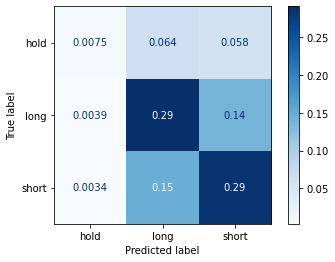

ZScorePredictor
Accuracy:  0.5830666666666666
Error Score: 6.1870666666666665


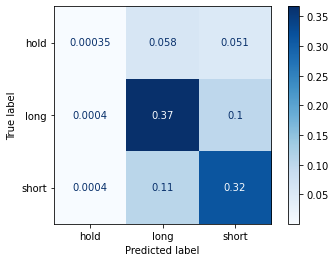

FiveDayPredictor
Accuracy:  0.6826133333333333
Error Score: 9.739733333333334


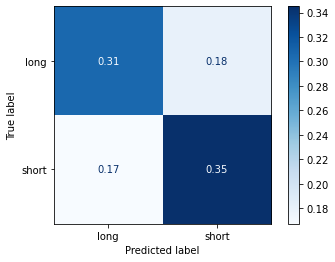

TmmrwUpPredictor
Accuracy:  0.65192
Error Score: 6.913466666666666


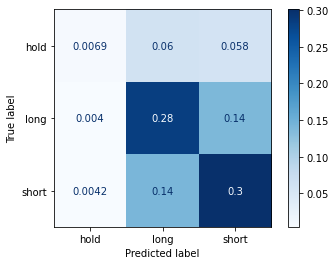

ZScorePredictor
Accuracy:  0.5926933333333333
Error Score: 6.499333333333333


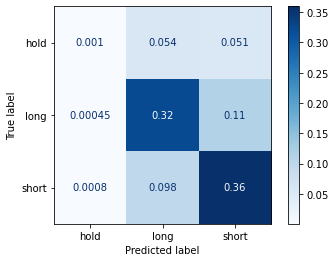

FiveDayPredictor
Accuracy:  0.6833333333333333
Error Score: 9.662266666666667


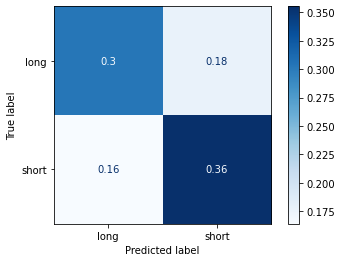

TmmrwUpPredictor
Accuracy:  0.6587733333333333
Error Score: 7.1710666666666665


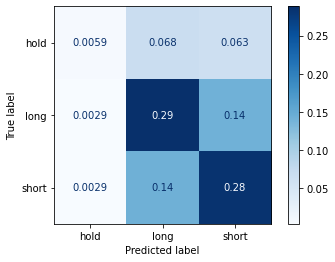

ZScorePredictor
Accuracy:  0.5783733333333333
Error Score: 6.136133333333333


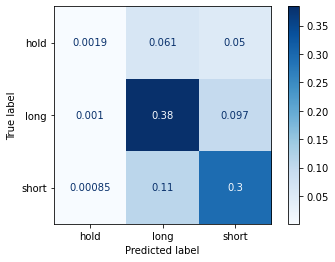

FiveDayPredictor
Accuracy:  0.6812533333333334
Error Score: 9.7024


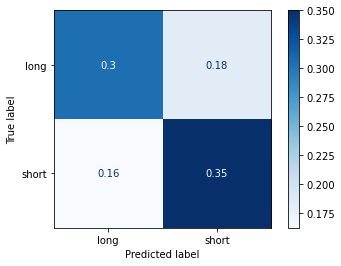

TmmrwUpPredictor
Accuracy:  0.6549333333333334
Error Score: 7.007333333333333


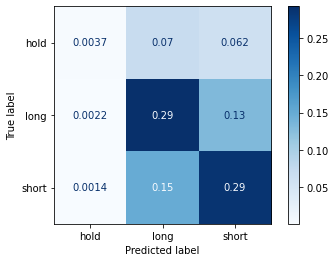

ZScorePredictor
Accuracy:  0.5830933333333334
Error Score: 6.360533333333334


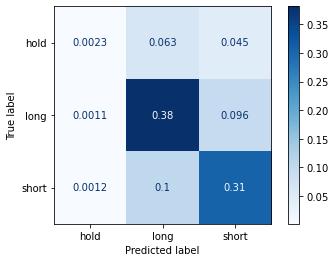

FiveDayPredictor
Accuracy:  0.69024
Error Score: 9.972933333333334


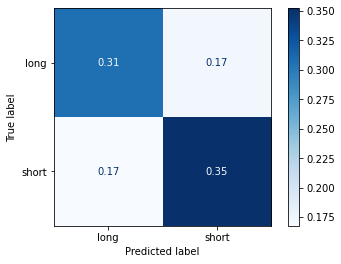

TmmrwUpPredictor
Accuracy:  0.6593333333333333
Error Score: 7.2112


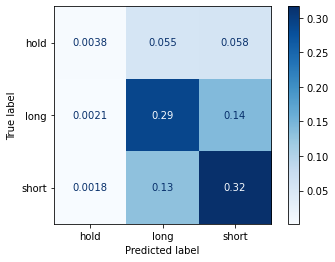

ZScorePredictor
Accuracy:  0.60992
Error Score: 7.05


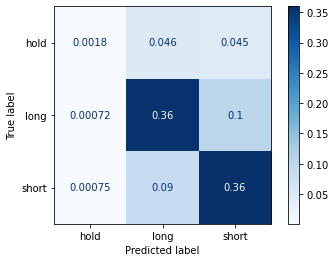

FiveDayPredictor
Accuracy:  0.7169333333333333
Error Score: 10.707066666666666


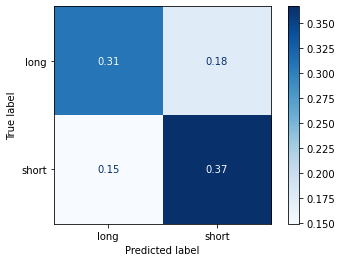

TmmrwUpPredictor
Accuracy:  0.6749333333333334
Error Score: 7.744933333333333


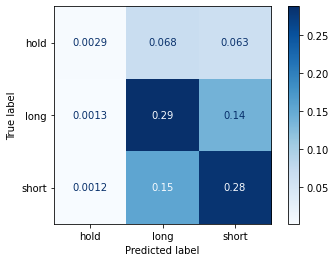

ZScorePredictor
Accuracy:  0.5730569948186528
Error Score: 5.967061435973353


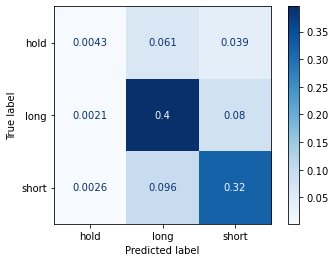

FiveDayPredictor
Accuracy:  0.71880088823094
Error Score: 10.941524796447077


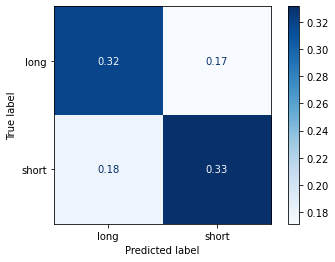

TmmrwUpPredictor
Accuracy:  0.6492227979274612
Error Score: 6.865655070318283
-------------------------------------------


Final Catboost accuracy:  0.6468052230172437
Final Catboost score:  7.879983776078076
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  1.393913
BOPGSTBValue                     3.390127
BOPGSTBbPercent                  3.871490
BOPGSTBfiveVsTenTickAverage      1.010927
BOPGSTBlastChangeP               5.371342
...                                   ...
titleSentChangeSinceYesterday   20.140012
todayZScore                     21.822234
totalVolumeOfTheDay             19.491392
typPrice                        79.365302
vsMarketPerformance             20.034787

[158 rows x 1 columns]
DPRIMElastChangeP
Utilities
-------------------------------------------


Final Catboost accuracy:  0.6572051246696541
Final Catboost score:  8.475206388601631
Final Feature Importance:         

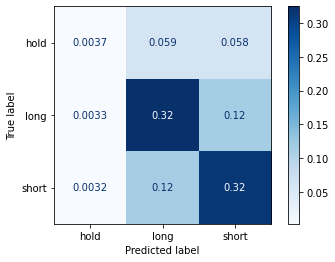

ZScorePredictor
Accuracy:  0.6438666666666667
Error Score: 8.439066666666667


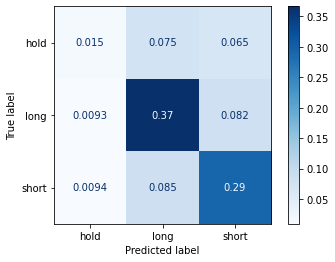

FiveDayPredictor
Accuracy:  0.6735466666666666
Error Score: 9.888133333333334


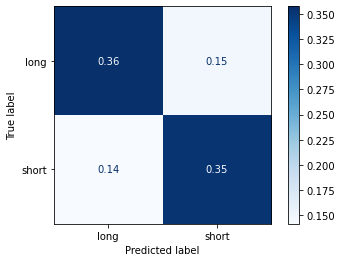

TmmrwUpPredictor
Accuracy:  0.70992
Error Score: 9.1052


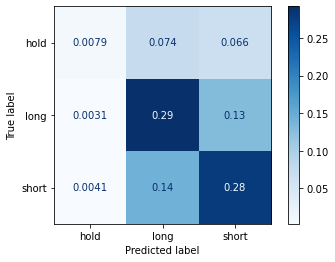

ZScorePredictor
Accuracy:  0.5787659427783522
Error Score: 6.285763529817304


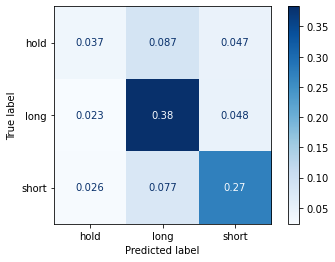

FiveDayPredictor
Accuracy:  0.6918304033092038
Error Score: 10.554981041020337


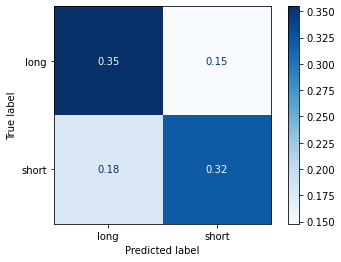

TmmrwUpPredictor
Accuracy:  0.6749396759738021
Error Score: 7.883488452257843
-------------------------------------------


Final Catboost accuracy:  0.662144892565782
Final Catboost score:  8.692772170515916
Final Feature Importance:                                importance
featureName                              
Asia (ex China)                  0.410259
BOPGSTBValue                     1.386847
BOPGSTBbPercent                  1.051289
BOPGSTBfiveVsTenTickAverage      0.925402
BOPGSTBlastChangeP               1.739081
...                                   ...
titleSentChangeSinceYesterday    5.295503
todayZScore                      6.787794
totalVolumeOfTheDay              5.118889
typPrice                        27.719072
vsMarketPerformance              5.972472

[158 rows x 1 columns]
DPRIMElastChangeP


In [5]:
for file in os.listdir(sectorFolder):
    sector = file.split('.')[0]
    print(sector)
    droppedColumns = []
    lastScore = 0
    lastAccuracy = 0
    toContinue = True
    newToRemove = None
    first = True
    oldScore = None
    while (toContinue):
        toRemove, newScore, colCount, _ = buildForest(file, droppedColumns, False)
        if not first:
            print('change in score by removing {} is {}'.format(toRemove, newScore - oldScore))
            if newScore <= oldScore :
                droppedColumns.pop()
                toContinue = False
            else:
                droppedColumns.append(toRemove)
                print(droppedColumns)
        else : #if first
            first = False
            droppedColumns.append(toRemove)
            print(droppedColumns)
        oldScore = newScore
    verbose = True
    buildForest(file, droppedColumns, True)     
    verbose = False

